In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from tqdm.notebook import tqdm_notebook, tnrange
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G,Gwavoriginal = np.zeros((ns,nr,nt)), - \
         np.zeros((ns,nr,nt))
for iy,y0 in enumerate(y):
    G[iy],Gwavoriginal[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G,Gwavoriginal = G*tap,Gwavoriginal*tap


Gwav = Gwavoriginal

In [3]:
# Add negative part to operator and model
ns = Gwav.shape[0]
m     = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav  = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)

Gwav2.shape

(101, 61, 799)

In [4]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(2*nt-1, ns)

Dot test passed, v^T(Opu)=-12276.927031+9003.146980i - u^T(Op^Tv)=-12276.927031+322.700832i


In [5]:

MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
d =  torch.from_numpy(d.astype(np.float32))
m  =  torch.from_numpy(m.astype(np.float32))
Gwav2 = torch.from_numpy(Gwav2.astype(np.float32))

d1 = MDCop.apply(m.flatten())
d1 = d1.view(2*nt-1, ns)

In [6]:
lossdict = {}
avgdict = {}

In [7]:
nv=1
class GwavSGD(nn.Module):
  def __init__(self,nt,nv,dt,dr,ns):
    self.nt = nt
    self.nv = nv
    self.dt = dt
    self.dr =dr
    self.ns = ns
    super().__init__()
    

  def forward(self,model, batch):
    batch_size = batch.shape[0]
    Gwav_fft = np.fft.rfft(batch, 2*nt-1, axis=-1)
    Gwav_fft = Gwav_fft[...,:nfmax]
    Gwav_fft = Gwav_fft.transpose(2,0,1)
    
    MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
    
    MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
    
    data = MDCop.apply(model.flatten())
    data = data.view(2*nt-1, batch_size)

    return data


In [8]:
def advoptMDD(model, optimizer, lr):
  if optimizer == 'SGD':

      optimizer = torch.optim.SGD([model], lr = lr)

  elif optimizer == 'ASGD':
    
     optimizer = torch.optim.ASGD([model], lr=lr)   
   
  elif optimizer == 'Adadelta':
   
      optimizer = torch.optim.Adadelta([model], lr =lr)
    
  elif optimizer == 'Adam':
   
      optimizer= torch.optim.Adam([model], lr=lr)
   

  elif optimizer == 'RMSprop':
  
      optimizer= torch.optim.RMSprop([model], lr =lr, weight_decay=1e-3, eps = 1e-04)
   

  elif optimizer == 'Adagrad':
  
      optimizer= torch.optim.Adagrad([model], lr = lr)

  elif optimizer == 'Adamax':

      optimizer = torch.optim.Adamax([model], lr=lr)

      
    

  return optimizer


In [9]:


def advancedSolvers(GwavSGD,model,d1,Gwav2,optimizer, lr, n_epochs, batch_size):

  d2 = torch.transpose(d1, 1,0)
  no_of_batches=round(Gwav2.shape[0]/batch_size)

 
  t_train = TensorDataset(Gwav2, d2)
  trainloader = DataLoader(dataset = t_train, batch_size = batch_size, shuffle = True)
  
  criterion = nn.MSELoss()
  optimizer = advoptMDD(model, optimizer, lr)

  
  GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
  lossHist=[]
  lossavg=[]
  for epoch in range(n_epochs):
    losses=[]
    
    for batch,dbatch in trainloader: 
      
       data = GwavTorch(model, batch)
       dbatch1 = torch.transpose(dbatch,1,0)
       loss = criterion(dbatch1, data)
       
       loss.backward()
       optimizer.step()
       optimizer.zero_grad()

       lossHist.append(loss.item())
       losses.append(loss.item())
      
      
    avg_loss = sum(losses) / len(losses)
    lossavg.append(avg_loss)
       
       
    
    if (epoch+1) %10 ==0:
     print(f'epoch: {epoch+1}, loss : {loss.item():.4f}, loss avg : {avg_loss:.4f}')
    

    lossdict[optimizer] = lossHist
    avgdict[optimizer] = lossavg

  return lossHist, lossavg



In [10]:
model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

In [11]:
n_epochs = 100
batch_size = 21
solver = advancedSolvers(GwavSGD,model,d1,Gwav2,'Adagrad', lr =0.01, n_epochs =n_epochs, batch_size = batch_size)

epoch: 10, loss : 0.0972, loss avg : 0.1054
epoch: 20, loss : 0.0597, loss avg : 0.0527
epoch: 30, loss : 0.0339, loss avg : 0.0329
epoch: 40, loss : 0.0237, loss avg : 0.0234
epoch: 50, loss : 0.0198, loss avg : 0.0179
epoch: 60, loss : 0.0136, loss avg : 0.0144
epoch: 70, loss : 0.0120, loss avg : 0.0121
epoch: 80, loss : 0.0101, loss avg : 0.0103
epoch: 90, loss : 0.0092, loss avg : 0.0091
epoch: 100, loss : 0.0083, loss avg : 0.0081


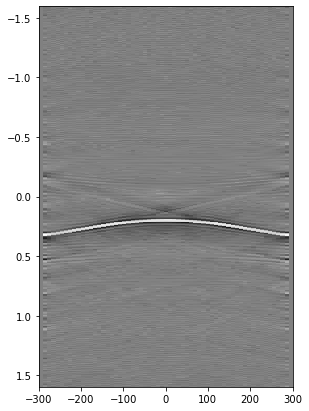

In [12]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

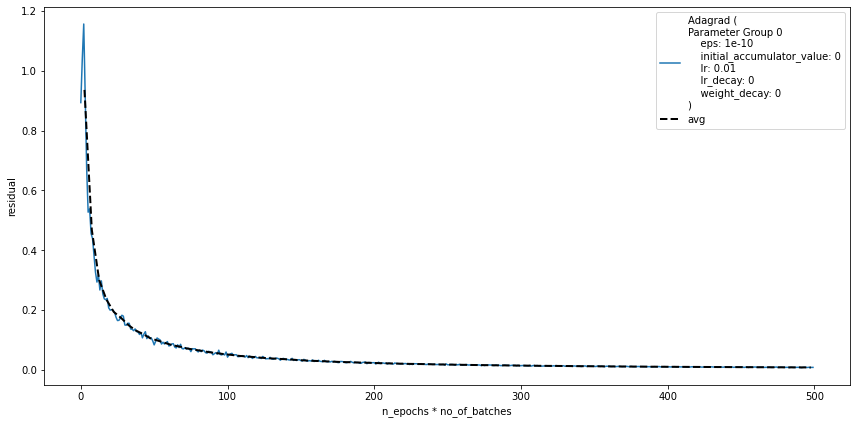

In [13]:
no_of_batches=round(Gwav2.shape[0]/batch_size)
for loss, avg in zip(lossdict.keys(), avgdict.keys()):
  fig = plt.figure(figsize= (12,6))
  plt.plot(lossdict[loss], label = loss)
  plt.plot(np.arange(0, no_of_batches*n_epochs, no_of_batches)+no_of_batches/2,avgdict[avg], 'k--',label = "avg", linewidth = 2)
  plt.xlabel('n_epochs * no_of_batches')
  plt.ylabel('residual')
  plt.legend()
  plt.tight_layout()

## Advanced solvers with lr_schedulers

In [14]:
sch_lossdict = {}
sch_avgdict = {}

In [15]:


def advancedSolvers_sch(GwavSGD,model,d1,Gwav2,optimizer, lr, n_epochs, batch_size):

  d2 = torch.transpose(d1, 1,0)
  no_of_batches=round(Gwav2.shape[0]/batch_size)
  print(Gwav2.shape, d2.shape, no_of_batches)

  t_train = TensorDataset(Gwav2, d2)
  trainloader = DataLoader(dataset = t_train, batch_size = batch_size, shuffle = True)
  print(len(trainloader))
  
  criterion = nn.MSELoss()
  optimizer = advoptMDD(model, optimizer, lr)


  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=5, cycle_momentum=False,  base_momentum=0.8, max_momentum=0.9,verbose=False)
  print(scheduler.get_lr())
  scheduler1 = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,epochs = n_epochs, steps_per_epoch = len(trainloader), cycle_momentum=False)
  print(scheduler.get_lr())
  

  GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
  lossHistt=[]
  lossavgg=[]
  for epoch in range(n_epochs):
    losses=[]
     
    for batch,dbatch in trainloader: 
      
       data = GwavTorch(model, batch)
       dbatch1 = torch.transpose(dbatch,1,0)
       loss = criterion(dbatch1, data)
       
       loss.backward()
       optimizer.step()
       optimizer.zero_grad()

       lossHistt.append(loss.item())
       losses.append(loss.item())
       
     
       scheduler.step()
       scheduler1.step()

    avg_loss = sum(losses) / len(losses)
    lossavgg.append(avg_loss)
       
       
    
    if (epoch+1) %10 ==0:
     print(f'epoch: {epoch+1}, loss : {loss.item():.4f}, loss avg : {avg_loss:.4f}')
    

    sch_lossdict[optimizer] = lossHistt
    sch_avgdict[optimizer] = lossavgg

  return lossHistt, lossavgg



In [16]:

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True


n_epochs = 100
batch_size = 21
solver = advancedSolvers_sch(GwavSGD,model,d1,Gwav2,'Adam', lr =0, n_epochs =n_epochs, batch_size = batch_size)

torch.Size([101, 61, 799]) torch.Size([101, 799]) 5
5
[0.001]
[0.001]
epoch: 10, loss : 0.3026, loss avg : 0.2775
epoch: 20, loss : 0.1070, loss avg : 0.1060
epoch: 30, loss : 0.1262, loss avg : 0.1285
epoch: 40, loss : 0.0957, loss avg : 0.1375
epoch: 50, loss : 0.0463, loss avg : 0.0476
epoch: 60, loss : 0.0128, loss avg : 0.0143
epoch: 70, loss : 0.0027, loss avg : 0.0027
epoch: 80, loss : 0.0019, loss avg : 0.0019
epoch: 90, loss : 0.0018, loss avg : 0.0018
epoch: 100, loss : 0.0018, loss avg : 0.0018


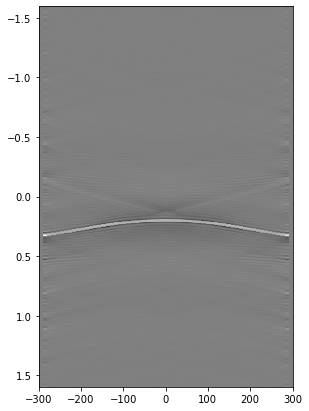

In [17]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

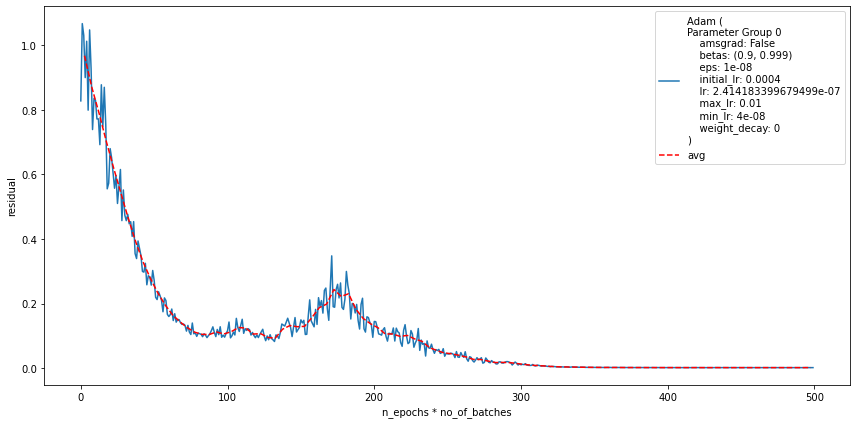

In [18]:
no_of_batches=round(Gwav2.shape[0]/batch_size)
for loss, avg in zip(sch_lossdict.keys(), sch_avgdict.keys()):
  fig = plt.figure(figsize= (12,6))
  plt.plot(sch_lossdict[loss], label = loss, linewidth = 1.5)
  plt.plot(np.arange(0, no_of_batches*n_epochs, no_of_batches)+no_of_batches/2,sch_avgdict[avg], 'r--',label = "avg")
  plt.xlabel('n_epochs * no_of_batches')
  plt.ylabel('residual')
  plt.legend()
  plt.tight_layout()

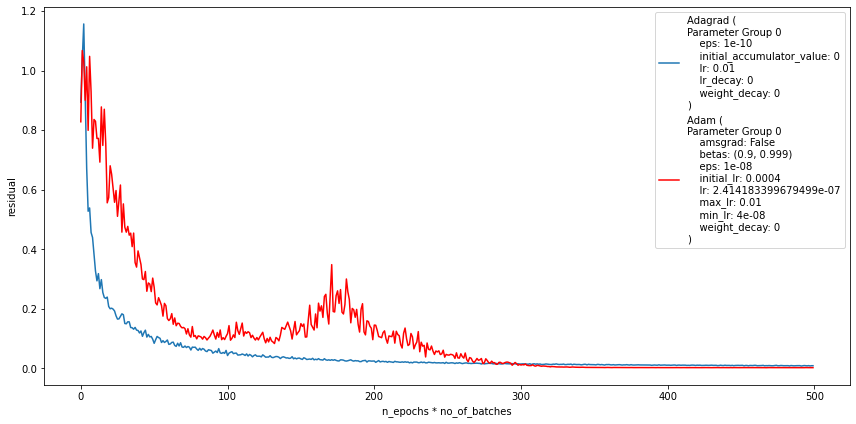

In [19]:
for loss, losssch in zip(lossdict.keys(), sch_lossdict.keys()):
  fig = plt.figure(figsize= (12,6))
  plt.plot(lossdict[loss], label = loss)
  plt.plot(sch_lossdict[losssch], 'r-',label = losssch,linewidth = 1.5)
  plt.xlabel('n_epochs * no_of_batches')
  plt.ylabel('residual')
  plt.legend()
  plt.tight_layout()

